In [10]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [11]:
import pandas
indoors_temp = pandas.read_csv("meter.csv", parse_dates=["Timestamp"], index_col="Timestamp")
indoors_temp.rename(columns={"Temperature_Celsius": "T", "Timestamp": "DateTime"}, inplace=True)

In [12]:
outdoors_temp = pandas.read_csv("knmi-344.txt", header=8)
outdoors_temp.rename(columns=lambda x: x.strip(), inplace=True)
outdoors_temp["T"]/=10
outdoors_temp["H"]-=1
outdoors_temp['DateTime']=pandas.to_datetime(outdoors_temp["YYYYMMDD"].map(str)+'/'+outdoors_temp["H"].map(str), format="%Y%m%d/%H")
outdoors_temp.set_index("DateTime", inplace=True)

In [13]:
aligned_data = {"T_IN": indoors_temp.reindex(indoors_temp.index.union(outdoors_temp.index)).interpolate('time').reindex(outdoors_temp.index)["T"],
                "T_OUT": outdoors_temp["T"],
                "DateTime": outdoors_temp.index}
data = pandas.DataFrame(aligned_data).round(1).dropna()
data.set_index("DateTime", inplace=True)
data["DELTA"] = data["T_IN"] - data["T_OUT"]
data["T_IN>=26.5"] = data["T_IN"] >= 26.5
data["DEFECTIVE"] = (data["DELTA"] >= 6.0) & (data["T_IN"] >= 26.5)

In [14]:
data

,T_IN,T_OUT,DELTA,T_IN>=26.5,DEFECTIVE
DateTime,,,,,
2022-08-06 20:00:00,29.1,13.2,15.9,True,True
2022-08-06 21:00:00,28.2,12.2,16.0,True,True
2022-08-06 22:00:00,28.2,12.0,16.2,True,True
2022-08-06 23:00:00,28.2,11.1,17.1,True,True
2022-08-07 00:00:00,28.2,11.5,16.7,True,True
...,...,...,...,...,...
2022-09-05 19:00:00,27.8,18.5,9.3,True,True
2022-09-05 20:00:00,27.4,18.9,8.5,True,True
2022-09-05 21:00:00,27.6,17.9,9.7,True,True


In [15]:
print(f"Total number of defective hours in 30 days: {data.DEFECTIVE.sum()} hours")
print("Number of defective hours per day:")
print(data.resample('D').sum().DEFECTIVE)

Total number of defective hours in 30 days: 513 hours
Number of defective hours per day:
DateTime
2022-08-06     4
2022-08-07    24
2022-08-08    23
2022-08-09    16
2022-08-10    12
2022-08-11    11
2022-08-12    11
2022-08-13    11
2022-08-14    11
2022-08-15    18
2022-08-16    17
2022-08-17    24
2022-08-18    19
2022-08-19    22
2022-08-20    22
2022-08-21    24
2022-08-22    12
2022-08-23    11
2022-08-24     8
2022-08-25    13
2022-08-26    24
2022-08-27    24
2022-08-28    23
2022-08-29    24
2022-08-30    18
2022-08-31    17
2022-09-01    16
2022-09-02    15
2022-09-03    13
2022-09-04    14
2022-09-05    12
Freq: D, Name: DEFECTIVE, dtype: int64


In [16]:
T_IN_threshold = np.arange(26.5, 28.5, 0.5)
DELTA_threshold = np.arange(6.0, 11.0)
num_hours_defective = np.empty([len(T_IN_threshold), len(DELTA_threshold)], dtype=np.int32)
for i, t_threshold in enumerate(T_IN_threshold):
    for j, d_threshold in enumerate(DELTA_threshold):
        num_hours_defective[i][j] = ((data["DELTA"] >= d_threshold) & (data["T_IN"] >= t_threshold)).sum()
dh = pandas.DataFrame(num_hours_defective, columns=DELTA_threshold, index=T_IN_threshold)
print("Number of hours with defective temperature in 30 days calculated with different thresholds\
for T_IN and DELTA. The thresholds are the row and column headers respectively.")
dh.index = np.round(dh.index, 1)
dh

Number of hours with defective temperature in 30 days calculated with different thresholdsfor T_IN and DELTA. The thresholds are the row and column headers respectively.


,6.0,7.0,8.0,9.0,10.0
26.5,513,447,383,308,231
27.0,474,408,348,275,202
27.5,377,319,271,213,148
28.0,254,211,177,135,88


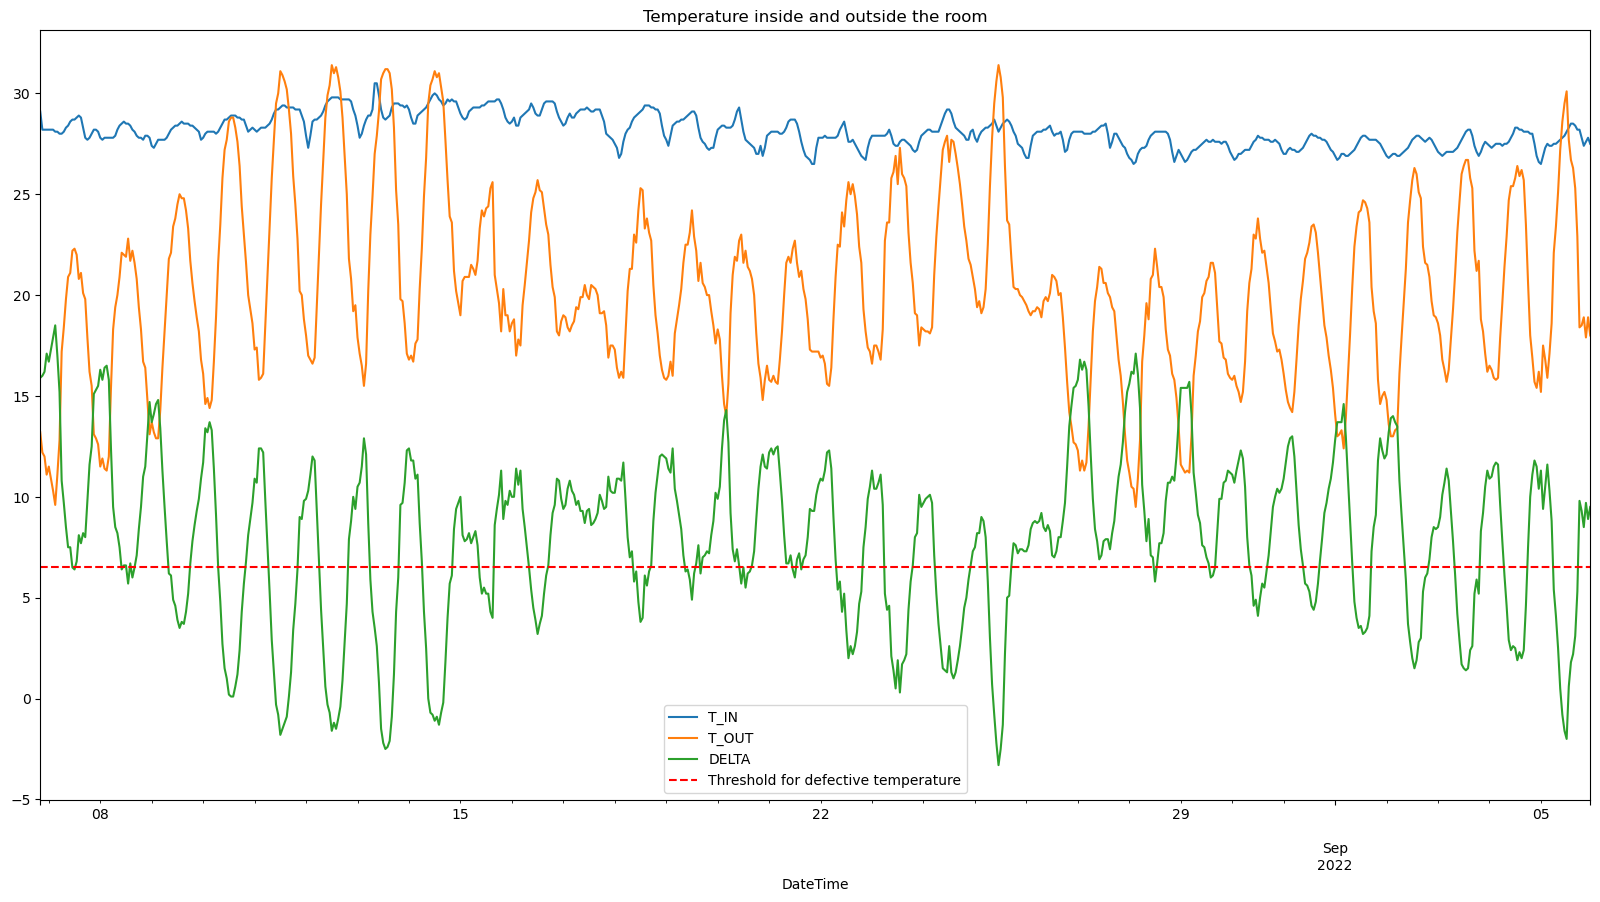

In [17]:
# Absolute Temperature Plot
data.plot(figsize=(20,10), title="Temperature inside and outside the room")
plt.axhline(y=6.5, color='r', linestyle='--', label="Threshold for defective temperature")
plt.legend()

Text(0, 0.5, 'Indoor Temperature')

<Figure size 2000x1000 with 0 Axes>

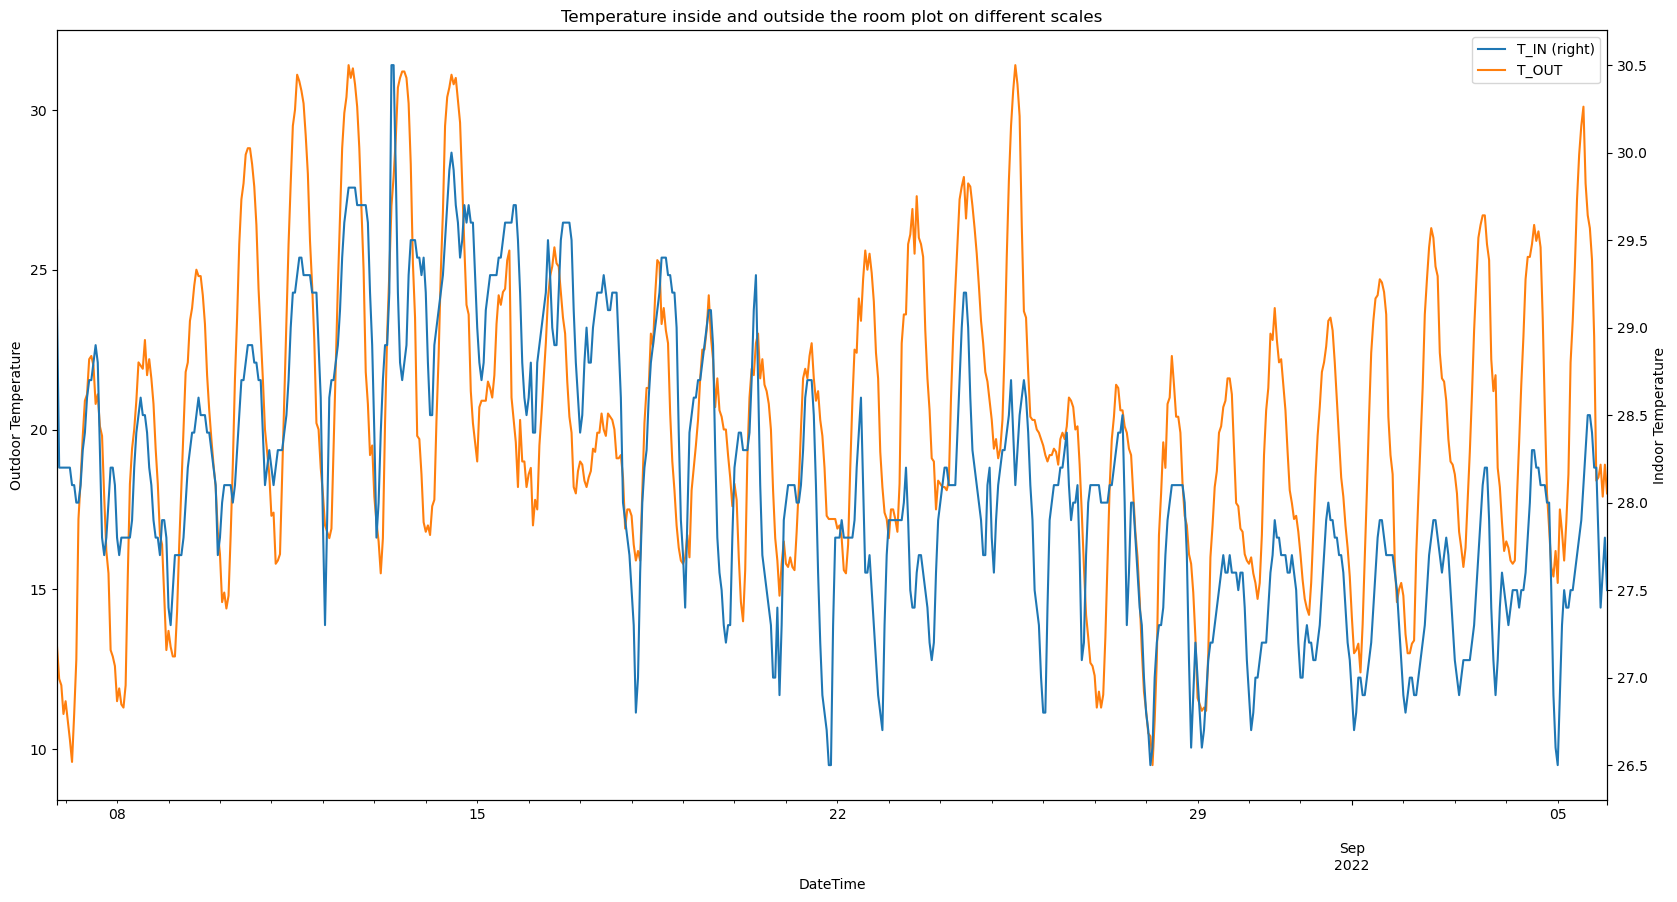

In [18]:
plt.figure(figsize=(20,10))
ax = data[["T_IN", "T_OUT"]].plot(secondary_y=["T_IN"], figsize=(20,10), title="Temperature inside and outside the room plot on different scales")
ax.set_ylabel("Outdoor Temperature")
ax.right_ax.set_ylabel("Indoor Temperature")